# Load and visualize UAS geographical zones of Metropolitan France

In [1]:
%load_ext lab_black

In [2]:
from shapely.geometry import Polygon, Point
import pandas as pd
from geopandas import GeoDataFrame
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

### Download UAS geographical zones data from SIA website: https://www.sia.aviation-civile.gouv.fr/

In [3]:
json_file_path = (
    "UASZones_2022-07-14_20220629.json"  # to be updated with latest AIRAC cycle
)

### Build a geodataframe with relevant information

In [4]:
def _circle_polygon(pt, radius: "m"):
    gdf = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[pt])  # WGS 84
    buffer_df = gpd.GeoDataFrame(
        geometry=gdf.to_crs(gdf.estimate_utm_crs()).buffer(radius).to_crs(gdf.crs)
    )
    return buffer_df.iloc[0]["geometry"]

In [5]:
def _geom(g):
    geom = None
    proj = g[0]["horizontalProjection"]
    if proj["type"] == "Polygon":
        geom = Polygon(proj["coordinates"][0])
    elif proj["type"] == "Circle":
        geom = _circle_polygon(Point(proj["center"]), proj["radius"])
    else:
        print("Error geometry type")
    return geom

In [6]:
df = pd.read_json(json_file_path, encoding="utf-8-sig")
features = (
    pd.DataFrame.from_dict(df.features.to_dict(), orient="index")
    .query("country == 'FXX'")
    .rename(columns={"geometry": "g"})
)
features["geometry"] = features.g.apply(_geom)
features["lowerVerticalReference"] = features.g.apply(
    lambda x: x[0]["lowerVerticalReference"]
)
features["upperVerticalReference"] = features.g.apply(
    lambda x: x[0]["upperVerticalReference"]
)
features["lowerLimit"] = features.g.apply(lambda x: x[0]["lowerLimit"])
features["upperLimit"] = features.g.apply(lambda x: x[0]["upperLimit"])
features["reason"] = features.reason.apply(lambda x: " ".join(x))
features = features[
    [
        "name",
        "geometry",
        "lowerLimit",
        "lowerVerticalReference",
        "upperLimit",
        "upperVerticalReference",
        "otherReasonInfo",
        "reason",
    ]
].reset_index(drop=True)
zones = GeoDataFrame(features, crs="EPSG:4326")  # WGS 84
zones.head()

name                                           geometry  \
0             [LF][D 5]  POLYGON ((-4.60639 49.53806, -5.50000 49.36139...   
1             [LF][D 7]  POLYGON ((-4.30500 48.96944, -5.05028 48.75056...   
2  [LF][D 12 GLOBALE A]  POLYGON ((-5.96667 48.80917, -6.86139 48.40917...   
3  [LF][D 12 GLOBALE B]  POLYGON ((-5.96667 48.80917, -6.86139 48.40917...   
4     [LF][D 12 NORD A]  POLYGON ((-5.96667 48.80917, -6.86139 48.40917...   

   lowerLimit lowerVerticalReference  upperLimit upperVerticalReference  \
0     5491.34                   AMSL     8697.88                   AMSL   
1     5491.34                   AMSL     8697.88                   AMSL   
2     5491.34                   AMSL     8697.88                   AMSL   
3     7929.77                   AMSL    30765.67                   AMSL   
4     5491.34                   AMSL     8697.88                   AMSL   

   otherReasonInfo reason  
0  Zone dangereuse  OTHER  
1  Zone dangereuse  OTHER  
2  Zone dangereuse  OTHER  
3  Zone dangereuse  OTHER  
4  Zone dangereuse  OTHER

### Save geodataframe as GeoJSON file

In [7]:
zones.to_file("uas_zones.geojson", driver="GeoJSON")

D:\tdubot\anaconda3\envs\env2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Load GeoJSON file and visualize UAS geographical zones on France map

In [8]:
uas_zones = gpd.read_file("uas_zones.geojson")
uas_zones.head()

name  lowerLimit lowerVerticalReference  upperLimit  \
0             [LF][D 5]     5491.34                   AMSL     8697.88   
1             [LF][D 7]     5491.34                   AMSL     8697.88   
2  [LF][D 12 GLOBALE A]     5491.34                   AMSL     8697.88   
3  [LF][D 12 GLOBALE B]     7929.77                   AMSL    30765.67   
4     [LF][D 12 NORD A]     5491.34                   AMSL     8697.88   

  upperVerticalReference  otherReasonInfo reason  \
0                   AMSL  Zone dangereuse  OTHER   
1                   AMSL  Zone dangereuse  OTHER   
2                   AMSL  Zone dangereuse  OTHER   
3                   AMSL  Zone dangereuse  OTHER   
4                   AMSL  Zone dangereuse  OTHER   

                                            geometry  
0  POLYGON ((-4.60639 49.53806, -5.50000 49.36139...  
1  POLYGON ((-4.30500 48.96944, -5.05028 48.75056...  
2  POLYGON ((-5.96667 48.80917, -6.86139 48.40917...  
3  POLYGON ((-5.96667 48.80917, -6.86139 48.40917...  
4  POLYGON ((-5.96667 48.80917, -6.86139 48.40917...

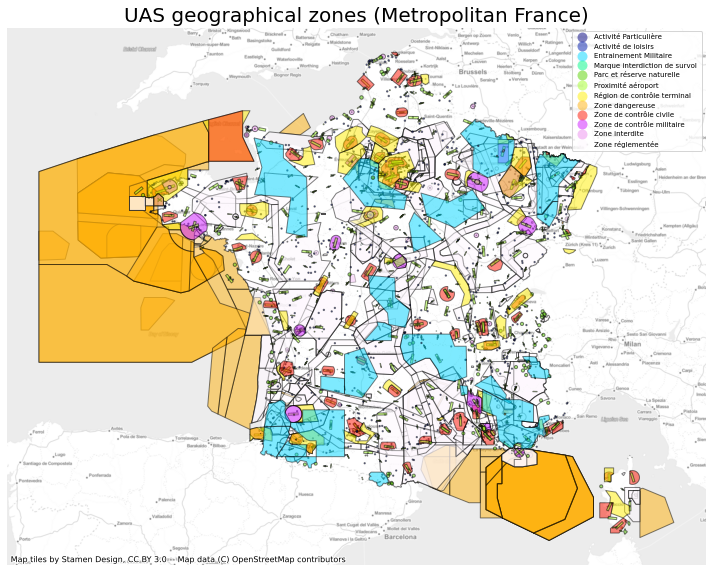

In [9]:
f, ax = plt.subplots(figsize=(10, 10))

uas_zones.to_crs(epsg=3857).plot(
    ax=ax,
    column="otherReasonInfo",
    categorical=True,
    cmap="gist_ncar",
    linewidth=1.0,
    edgecolor="black",
    legend=True,
    alpha=0.5,
    legend_kwds={"loc": 1, "fontsize": 7},
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite, alpha=0.5)
ax.axis("off")
ax.set_title("UAS geographical zones (Metropolitan France)", fontsize=20)
plt.tight_layout()
plt.savefig("france.png", dpi=150, bbox_inches="tight")

### Visualize UAS geographical zones (interactive map)

In [10]:
tooltip = [
    "name",
    "otherReasonInfo",
    "reason",
    "lowerLimit",
    "lowerVerticalReference",
    "upperLimit",
    "upperVerticalReference",
]
m = uas_zones.explore(
    "otherReasonInfo",
    cmap="gist_ncar",
    tooltip=tooltip,
    style_kwds={"color": "black", "fillOpacity": 0.4, "weight": 0.8},
)
m.save("uas_geographical_zones.html")
m